In [1]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image
from nibabel.testing import data_path
import os
import sys
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import scipy.optimize as optimization

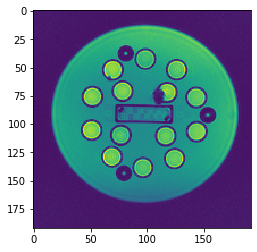

In [23]:
import pydicom
MapAngles_defaut = np.zeros([192,192,7])
MapAngles_defaut[:,:,0] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0003.0009.2020.11.19.21.00.11.258356.259817697.IMA").pixel_array
#MapAngles_defaut[:,:,0] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0009.0009.2020.11.19.21.00.11.258356.259823853.IMA").pixel_array
MapAngles_defaut[:,:,1] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0004.0009.2020.11.19.21.00.11.258356.259818723.IMA").pixel_array
MapAngles_defaut[:,:,2] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0005.0009.2020.11.19.21.00.11.258356.259819749.IMA").pixel_array
MapAngles_defaut[:,:,3] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0006.0009.2020.11.19.21.00.11.258356.259820775.IMA").pixel_array
MapAngles_defaut[:,:,4] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0007.0009.2020.11.19.21.00.11.258356.259821801.IMA").pixel_array
MapAngles_defaut[:,:,5] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0008.0009.2020.11.19.21.00.11.258356.259822827.IMA").pixel_array
MapAngles_defaut[:,:,6] = pydicom.read_file("AGAH_NIST_ACHILLE.MR.IRM_RECHERCHE_NIKOLA_STIKOV.0009.0009.2020.11.19.21.00.11.258356.259823853.IMA").pixel_array

plt.imshow(MapAngles_defaut[:,:,1])

In [4]:
#from scipy.optimize import leastsq
#Ancienne version (sans estimation de M0)
def residual(variables, x, data, M0,eps_data):
    """Model a decaying sine wave and subtract data."""
    T1 = variables[0]

    model = M0*((1-np.exp(-15/T1))/(1-np.cos(np.deg2rad(x))*np.exp(-15/T1)))*np.sin(np.deg2rad(x))

    return (data-model) / eps_data

In [5]:
#Avec utilisation de M0
def func(x, T1, M0):
    """Model a decaying sine wave and subtract data."""
    return M0*((1-np.exp(-15/T1))/(1-np.cos(np.deg2rad(x))*np.exp(-15/T1)))*np.sin(np.deg2rad(x))

In [6]:
def T1_non_lin(MapAngles, angles, TF, T1_estim):
    eps_data =1
    T1graph = np.ones([MapAngles.shape[0], MapAngles.shape[1]])
    x0 = [1000, 5000]
    for i in range(0, MapAngles.shape[0]):  
        for j in range(0,MapAngles.shape[1]):
            coordx=i
            coordy=j
            Magnt = MapAngles[coordx, coordy, :]
            T1 = (optimization.curve_fit(func, angles, Magnt, x0)[0])[0]
            if(T1<4000 and T1>0): 
                T1graph[coordx][coordy] = T1
    return T1graph

In [7]:
def T1_lin(Map1, Map2, angles, TF): #B1?
    T1graph = np.zeros(Map1.shape)
    for i in range(0,Map1.shape[0]):
        for j in range(0,Map1.shape[1]):
            coordx=i
            coordy=j
            pente = ((Map2[coordx][coordy]/np.sin(np.deg2rad(angles[1])))-(Map1[coordx][coordy]/np.sin(np.deg2rad(angles[0]))))/((Map2[coordx][coordy]/np.tan(np.deg2rad(angles[1])))-(Map1[coordx][coordy]/np.tan(np.deg2rad(angles[0]))))
            if (pente > 0):
                T1 = -TF/(np.log(pente))
                if (T1 < 4000) and (T1 > 0):
                    T1graph[coordx][coordy] = T1
    return T1graph

In [8]:
def load_image(MapAngles, adresse, position):
    image = pydicom.read_file(adresse).pixel_array
    if (position >= MapAngles[0,0,:].size):
        Map_temp = np.zeros([192, 192, position+1])
        for i in range (0, position):
            Map_temp[:,:,i] = MapAngles[:,:,i]
        MapAngles = Map_temp
        MapAngles[:,:,position]=image
    else:
        MapAngles[:,:,position]=image
    return MapAngles

In [9]:
import codecs, json 

In [10]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [11]:
from scipy.ndimage import convolve

In [12]:
#Test lissage
#mask_gauss = np.array([[1,2,1],[2,4,2],[1,2,1]])/16
#mask_moyen = np.ones([3, 3])/9
#for i in range (0, MapAngles_defaut_nf[0,0,:].size):
#    MapAngles_defaut[:,:, i] = convolve(MapAngles_defaut_nf[:,:, i], mask_moyen)
#plt.imshow(MapAngles_defaut[:, :, 0])

In [13]:
def choix_point(x):
    return {
        'Point 1 (103, 43)': [[101,102, 103,104,105],[41,42,43,44,45]],
        'Point 2 (128, 52)': [[126,127,128,129,130],[50,51,52,53,54]],
        'Point 3 (145, 77)': [[143,144,145,146,147],[75,76,77,78,79]],
        'Point 5(1) (146, 107)': [[144,145,146,147,148],[105,106,107,108,109]],
        'Point 5(2) (126, 130)': [[124,125,126,127,128],[128,129,130,131,132]],
        'Point 6 (99, 139)': [[97,98,99,100,101],[137,138,139,140,141]],
        'Point 7 (70, 130)': [[68,69,70,71,72],[128,129,130,131,132]],
        'Point 8 (52, 105)': [[50,51,52,53,54],[103,104,105,106,107]],
        'Point 9 (54, 76)': [[52,53,54,55,56],[74,75,76,77,78]],
        'Point 10 (72, 53)': [[70,71, 72,73,74],[51,52,53,54,55]],
        'Point 11 (81, 71)': [[79,80,81,82,83],[69,70,71,72,73]],
        'Point 12 (120, 72)': [[118,119,120,121,122],[70,71,72,73,74]],
        'Point 14 (79, 109)': [[77,78,79,80,81],[107,108,109,110,111]],
        'Point 15 (118, 110)': [[116,117,118,119,120],[108,109,110,111,112]],
    }[x]

In [14]:
print(choix_point('Point 1 (103, 43)')[0][2])
#print(np.zeros([3,3]))

103


In [24]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets, suppress_callback_exceptions=True)

all_options = {
    '3 deg': [],
    '5 deg': [],
    '10 deg': [],
    '15 deg': [],
    '20 deg': [],
    '25 deg': [],
    '30 deg': []
} 
MapAngles_new = np.zeros([192,192,1])
app.layout = html.Div([
    html.Div([
    dcc.Input(id='input-1-state', type='text', value='Adresse'),
    dcc.Input(id='input-2-state', type='number', value=0),
    html.Button(id='submit-button-state', n_clicks=0, children='Submit'),
    html.Div(id='output-state')
]),
    html.Div([
        html.Button(id='calcul', n_clicks=0, children='Submit'),
]),
    dcc.RadioItems(
        id='angles',
        options=[{'label': k, 'value': k} for k in all_options.keys()],
        value='3 deg',
        style={'width': '10%', 'display': 'inline-block'}
    ),
    dcc.Graph(
        id='angle-graph',
        figure=px.imshow(MapAngles_defaut[:,:,0], range_color=[0, 3500]),
        style={'width': '40%', 'display': 'inline-block'}
    ),

    #html.Hr(),

    dcc.RadioItems(
        id='methodes',
        options=[{'label': k, 'value': k} for k in ['T1 lin', 'T1 non_lin']],
        value='T1 linéaire',
        style={'width': '10%', 'display': 'inline-block'}
    ),
    dcc.Graph(
        id='T1-graph',
        figure=px.imshow(np.zeros([192, 192])),
        style={'display': 'inline-block', 'width': '40%'}
    ),
    html.Hr(),
    html.Div([
#    dcc.Input(
#        id='coordx',
#        type='number',
#        value=90
#    ),
#    dcc.Input(
#        id='coordy',
#        type='number',
#        value=90
#    ),
    dcc.RadioItems(
        id='point',
        options=[{'label': k, 'value': k} for k in ['Point 1 (103, 43)','Point 2 (128, 52)','Point 3 (145, 77)','Point 5(1) (146, 107)','Point 5(2) (126, 130)','Point 6 (99, 139)','Point 7 (70, 130)','Point 8 (52, 105)','Point 9 (54, 76)','Point 10 (72, 53)','Point 11 (81, 71)','Point 12 (120, 72)','Point 14 (79, 109)','Point 15 (118, 110)']],
        value='Point 1 (103, 43)',
        style={'width': '10%', 'display': 'inline-block'}
    ),
    dcc.Graph(
        id='graph-courbes',
        style={'display': 'inline-block', 'width': '90%'}),
    dcc.Graph(
        id='graph-lin',
        style={'display': 'inline-block', 'width': '90%'}),    
    ]), #style={'display': 'inline-block', 'width': '50%'}),
    
    html.Hr(),
    html.Div(id='intermediate-value', style={'display': 'none'}),
])



@app.callback(
    Output('intermediate-value', 'children'),
    Input('submit-button-state', 'n_clicks'),
    State('input-1-state', 'value'),
    State('input-2-state', 'value'),
    State('intermediate-value', 'children')
)
def clean_data(bouton, value, position, MapAngles_new):
    if(MapAngles_new == None):
        MapAngles_new = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_new)
        MapAngles_new = np.asarray(json_load["b"])
    MapAngles_new = load_image(MapAngles_new, value, position)
    b = MapAngles_new.tolist() 
    return json.dumps({'b': b}, cls=NumpyEncoder)

@app.callback(
    Output('angle-graph', 'figure'),
    Input('calcul', 'n_clicks'),
    Input('angles', 'value'),
    State('intermediate-value', 'children')
)
def update_figure(calcul, selected_country, MapAngles_affichage):
    if(MapAngles_affichage == None):
        MapAngles_affichage = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_affichage)
        MapAngles_affichage = np.asarray(json_load["b"])
    if (selected_country == '3 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,0], range_color=[0, 3500], labels = dict(color = "Mz"))
    if (selected_country == '5 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,1], range_color=[0, 3500], labels = dict(color = "Mz"))  
    if (selected_country == '10 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,2], range_color=[0, 3500], labels = dict(color = "Mz"))
    if (selected_country == '15 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,3], range_color=[0, 3500], labels = dict(color = "Mz"))
    if (selected_country == '20 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,4], range_color=[0, 3500], labels = dict(color = "Mz"))
    if (selected_country == '25 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,5], range_color=[0, 3500], labels = dict(color = "Mz"))
    if (selected_country == '30 deg'):
        fig = px.imshow(MapAngles_affichage[:,:,6], range_color=[0, 3500], labels = dict(color = "Mz"))     
    return fig

@app.callback(
    Output('T1-graph', 'figure'),
    Input('methodes', 'value'),
    Input('calcul', 'n_clicks'),
    State('intermediate-value', 'children'),
)
def update_figure2(selected_method, bouton, MapAngles_T1):
    if(MapAngles_T1 == None):
        MapAngles_T1 = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_T1)
        MapAngles_T1 = np.asarray(json_load["b"])
    if (selected_method == 'T1 non_lin'):
        angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
        T1graph_non_lin = T1_non_lin(MapAngles_T1, angles, 15, 1000)
        fig = px.imshow(T1graph_non_lin, range_color=[0, 3500], labels = dict(color = "ms"))
    if (selected_method == 'T1 lin'):
        angles = np.array([3.0,30.0])
        T1graph_lin = T1_lin(MapAngles_T1[:,:,0],MapAngles_T1[:,:,6], angles, 15)
        fig = px.imshow(T1graph_lin, range_color=[0, 3500], labels = dict(color = "ms"))   
    return fig

@app.callback(
    Output('graph-courbes', 'figure'),
#    Input('coordx', 'value'),
#    Input('coordy', 'value'),
    Input('point', 'value'),
    Input('calcul', 'n_clicks'),
    State('intermediate-value', 'children'),
)

def update_figure3(point, bouton, MapAngles_courbes):
    
    if(MapAngles_courbes == None):
        MapAngles_courbes = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_courbes)
        MapAngles_courbes = np.asarray(json_load["b"])
    angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
    angles2 = np.array([3.0, 30.0])
    x0 = [1000, 5000]
    T1lin_matrice = np.zeros([5,5])
    T1non_lin_matrice = np.zeros([5,5])
    M0_matrice = np.zeros([5,5])
    vraies_donnes_matrice = np.zeros([5,5,7])
    for i in range (0,5):
        selected_coordy = choix_point(point)[0][i]
        for j in range (0,5):
            selected_coordx = choix_point(point)[1][j]
            vraies_donnes_matrice[i,j,:] = MapAngles_courbes[selected_coordx, selected_coordy,:]
            pente = ((MapAngles_courbes[selected_coordx, selected_coordy,6]/np.sin(np.deg2rad(angles2[1])))-(MapAngles_courbes[selected_coordx, selected_coordy,0]/np.sin(np.deg2rad(angles2[0]))))/((MapAngles_courbes[selected_coordx, selected_coordy,6]/np.tan(np.deg2rad(angles2[1])))-(MapAngles_courbes[selected_coordx, selected_coordy,0]/np.tan(np.deg2rad(angles2[0]))))
            if (pente > 0):
                T1lin_matrice[i][j] = -15/(np.log(pente))
            T1non_lin_matrice[i][j] = (optimization.curve_fit(func, angles, MapAngles_courbes[selected_coordx, selected_coordy,:], x0)[0])[0]
            M0_matrice[i][j] =(optimization.curve_fit(func, angles, MapAngles_courbes[selected_coordx, selected_coordy,:], x0)[0])[1]
    vraies_donnes = np.zeros(7)
    for i in range (0,7):
        vraies_donnes[i] = np.mean(vraies_donnes_matrice[:,:,i])
    T1lin = np.mean(T1lin_matrice)
    T1non_lin = np.mean(T1non_lin_matrice)
    M0 = np.mean(M0_matrice)
    model_lin = M0*((1-np.exp(-15/T1lin))/(1-np.cos(np.deg2rad(angles))*np.exp(-15/T1lin)))*np.sin(np.deg2rad(angles))
    model_non_lin = M0*((1-np.exp(-15/T1non_lin))/(1-np.cos(np.deg2rad(angles))*np.exp(-15/T1non_lin)))*np.sin(np.deg2rad(angles))
    fig = px.scatter()#x="Angles", y = "Valeur du signal")
    fig.add_trace(go.Scatter(x=angles, y=vraies_donnes, name = "Valeurs réelles du signal"))
    fig.add_trace(go.Scatter(x=angles, y=model_lin, name = "Estimation linéaire"))
    fig.add_trace(go.Scatter(x=angles, y=model_non_lin, name = "Estimation non-linéaire"))
    fig.update_layout(
    #height=800,
    title_text=('T1 linéaire = '+str(T1lin)+' T1 non-linéaire = '+str(T1non_lin)),
    xaxis_title="Angles (deg)",
    yaxis_title="Mz", 
    )
    return fig

@app.callback(
    Output('graph-lin', 'figure'),
#    Input('coordx', 'value'),
#    Input('coordy', 'value'),
    Input('point', 'value'),
    Input('calcul', 'n_clicks'),
    State('intermediate-value', 'children'),
)

def update_figure4(point, bouton, MapAngles_courbes):
    if(MapAngles_courbes == None):
        MapAngles_courbes = MapAngles_defaut
    else:
        json_load = json.loads(MapAngles_courbes)
        MapAngles_courbes = np.asarray(json_load["b"])
    angles = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0])
    angles2 = np.array([3.0, 30.0])
    x0 = [1000, 5000]
    T1lin_matrice = np.zeros([5,5])
    T1non_lin_matrice = np.zeros([5,5])
    M0_matrice = np.zeros([5,5])
    vraies_donnes_matrice = np.zeros([5,5,7])
    for i in range (0,5):
        selected_coordy = choix_point(point)[0][i]
        for j in range (0,5):
            selected_coordx = choix_point(point)[1][j]
            vraies_donnes_matrice[i,j,:] = MapAngles_courbes[selected_coordx, selected_coordy,:]
            pente = ((MapAngles_courbes[selected_coordx, selected_coordy,6]/np.sin(np.deg2rad(angles2[1])))-(MapAngles_courbes[selected_coordx, selected_coordy,0]/np.sin(np.deg2rad(angles2[0]))))/((MapAngles_courbes[selected_coordx, selected_coordy,6]/np.tan(np.deg2rad(angles2[1])))-(MapAngles_courbes[selected_coordx, selected_coordy,0]/np.tan(np.deg2rad(angles2[0]))))
            if (pente > 0):
                T1lin_matrice[i][j] = -15/(np.log(pente))
                T1non_lin_matrice[i][j] = (optimization.curve_fit(func, angles, MapAngles_courbes[selected_coordx, selected_coordy,:], x0)[0])[0]
                M0_matrice[i][j] =(optimization.curve_fit(func, angles, MapAngles_courbes[selected_coordx, selected_coordy,:], x0)[0])[1]
    vraies_donnes = np.zeros(7)
    for i in range (0,7):
        vraies_donnes[i] = np.mean(vraies_donnes_matrice[:,:,i])
    T1lin = np.mean(T1lin_matrice)
    T1non_lin = np.mean(T1non_lin_matrice)
    M0 = np.mean(M0_matrice)
    model_lin = M0*((1-np.exp(-15/T1lin))/(1-np.cos(np.deg2rad(angles))*np.exp(-15/T1lin)))*np.sin(np.deg2rad(angles))
    model_non_lin = M0*((1-np.exp(-15/T1non_lin))/(1-np.cos(np.deg2rad(angles))*np.exp(-15/T1non_lin)))*np.sin(np.deg2rad(angles))
    fig = px.scatter()#x="Angles", y = "Valeur du signal")
    x_vrai_mod = vraies_donnes/np.sin((np.deg2rad(angles)))
    y_vrai_mod = vraies_donnes/np.tan((np.deg2rad(angles)))
    x_lin_mod = model_lin/np.sin((np.deg2rad(angles)))
    y_lin_mod = model_lin/np.tan((np.deg2rad(angles)))
    x_non_lin_mod = model_non_lin/np.sin((np.deg2rad(angles)))
    y_non_lin_mod = model_non_lin/np.tan((np.deg2rad(angles)))
    fig.add_trace(go.Scatter(x=x_vrai_mod, y=y_vrai_mod, name = "Valeurs réelles du signal"))
    fig.add_trace(go.Scatter(x=x_lin_mod, y=y_lin_mod, name = "Estimation linéaire"))
    fig.add_trace(go.Scatter(x=x_non_lin_mod, y=y_non_lin_mod, name = "Estimation non-linéaire"))
    fig.update_layout(
    #height=800,
    title_text=('T1 linéaire = '+str(T1lin)+' T1 non-linéaire = '+str(T1non_lin)),
    xaxis_title="Mz/sin(θ)",
    yaxis_title="Mz/tan(θ)", 
    )
    return fig

if __name__ == '__main__':
#    app.run_server(debug=True)
    app.run_server(mode='external', port=8060)

Dash app running on http://127.0.0.1:8060/


C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars

